# KeyBERT with Post-hoc Sentiment-aware Re-ranking

This notebook implements a **post-hoc sentiment-aware extension** of KeyBERT, where the original ranking of candidate keywords — based purely on cosine similarity — is adjusted using a **sentiment alignment score**. 

[!!!] The goal is to favour keywords that are not only semantically related to the document, but also **emotionally coherent** with its overall polarity.

---

## Approach

The method keeps the **original KeyBERT pipeline untouched** during keyword generation, but modifies the **ranking step** by incorporating a sentiment consistency factor.

Let:
- `cos_sim`: the original cosine similarity between a candidate keyword and the document
- `s_doc`: sentiment polarity of the full document (range: \[-1, +1\])
- `s_kw`: sentiment polarity of a candidate keyword (range: \[-1, +1\])

We define a **sentiment alignment score** as:

$$
\text{align}(s_{doc}, s_{kw}) = 1 - \frac{|s_{doc} - s_{kw}|}{2}
$$

This value ranges from 0 (opposite polarity) to 1 (perfect alignment).  
The final score is computed as:

$$
\text{score}_{\text{final}} = (1 - \alpha)\,\text{cos\_sim} + \alpha\,\text{align}
$$

Where **α ∈ [0, 1]** is a tunable parameter controlling the trade-off between semantic similarity and emotional consistency.

---

## Characteristics

- **Non-intrusive**: can be applied to any KeyBERT model without changing its inner workings.
- **Model-agnostic**: works with any sentiment scoring backend (e.g., RoBERTa, VADER).
- **Tunable**: α controls the influence of sentiment alignment.
- **Limitation**: does not change the candidate pool but only their final ranking.

---

This implementation serves as a **baseline sentiment-aware extension** to compare against both the standard KeyBERT pipeline and more involved sentiment-aware strategies (e.g., candidate filtering).


### Setup: Installing and Importing Required Libraries

In [47]:
import subprocess
import sys

# List of required packages
required_packages = [
    "keybert", "typing", "vaderSentiment.vaderSentiment", "tqdm", "matplotlib", 
    "seaborn", "pandas", "wordcloud", "collections", "pickle"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)

keybert is already installed.
typing is already installed.
vaderSentiment.vaderSentiment is already installed.
tqdm is already installed.
matplotlib is already installed.
seaborn is already installed.
pandas is already installed.
wordcloud is already installed.
collections is already installed.
pickle is already installed.


In [ ]:
from typing import List, Sequence, Tuple, Union
from keybert import KeyBERT

# Sentiment scoring utility using VADER
# We use VADER because it is lightweight, rule-based, and optimized for short texts (e.g., social media, reviews).
# It does not require GPU or large models, making it ideal for rapid prototyping and resource-constrained setups.
# The implementation remains modular, allowing easy extension to transformer-based sentiment models (e.g., RoBERTa).
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [12]:
# KeyBERT Post-hoc Sentiment-Aware Re-ranking

# This module extends KeyBERT to include sentiment-aware keyword extraction by defining 
# a subclass of KeyBERT that modifies the scoring phase to incorporate sentiment alignment 
# in a post-processing step. The goal is to boost keywords that are both semantically relevant 
# and emotionally aligned with the overall sentiment of the input review.

# Initialize VADER sentiment analyzer globally for reuse
_analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment polarity for a given text
# The default mode uses VADER, which returns a 'compound' score in [-1, +1]
def get_sentiment_score(text: str, mode: str = "vader") -> float:
    if mode == "vader":
        return _analyzer.polarity_scores(text)["compound"]
    else:
        raise ValueError(f"Unsupported sentiment mode: {mode}")

# Sentiment-Aware KeyBERT Class
class SentimentAwareKeyBERT(KeyBERT):
    """
    A KeyBERT extension that performs sentiment-aware post-hoc re-ranking.

    Parameters
    ----------
    model : str or SentenceTransformer
        The embedding model used to generate document and keyword embeddings.
        By default, we use 'all-MiniLM-L6-v2', a lightweight and efficient SBERT model
        that balances speed and semantic accuracy.

    alpha : float, default=0.25
        This parameter controls the trade-off between semantic similarity and sentiment alignment.
        When alpha = 0, only cosine similarity is considered (i.e., standard KeyBERT).
        When alpha = 1, only sentiment alignment is used. 
        A mid-value like 0.25 allows semantic meaning to dominate while still incorporating sentiment consistency.

    senti_mode : str, default="vader"
        Specifies which sentiment analysis model or backend to use.
        This implementation uses only VADER, but the design supports future extensions
        such as transformer-based sentiment models (e.g., RoBERTa, DistilBERT).
    """

    def __init__(
        self,
        model: Union[str, "SentenceTransformer"] = "sentence-transformers/all-MiniLM-L6-v2",
        *,
        alpha: float = 0.25,
        senti_mode: str = "vader",
        **kwargs,
    ) -> None:
        super().__init__(model=model, **kwargs)
        if not 0.0 <= alpha <= 1.0:
            raise ValueError("alpha must be in the interval [0, 1]")
        self.alpha = alpha
        self.senti_mode = senti_mode

    def extract_keywords(
        self,
        docs: Union[str, Sequence[str]],
        *,
        top_n: int = 10,
        **kwargs,
    ) -> List[List[Tuple[str, float]]]:
        """
        Returns top-n keywords using sentiment-aware re-ranking.

        Steps:
        1. Use standard KeyBERT to extract candidate keywords and cosine similarity scores.
        2. Compute sentiment polarity scores for the full review and each keyword.
        3. For each keyword, calculate an alignment score with the review's sentiment.
        4. Fuse cosine similarity and alignment using the alpha parameter.
        5. Return the top-n keywords sorted by the new combined score.
        """

        # Normalize input to a list of reviews
        if isinstance(docs, str):
            docs = [docs]
            single_doc = True
        else:
            single_doc = False

        # Step 1: extract keywords from KeyBERT
        # Output: base_keywords[review_index] = List[Tuple[keyword, cosine_sim]]
        base_keywords = super().extract_keywords(docs, top_n=top_n, **kwargs)

        # Ensure base_keywords is always List[List[Tuple[str, float]]] even if there is only 1 review
        if isinstance(base_keywords, list) and all(isinstance(k, tuple) for k in base_keywords):
            base_keywords = [base_keywords]  # wrap single result in a list


        # Step 2: compute sentiment for each review
        # Output: doc_sentiments[review_index] = float in [-1, +1]
        doc_sentiments = [get_sentiment_score(doc, mode=self.senti_mode) for doc in docs]

        # Step 3–4: re-rank using sentiment alignment
        # Output: reranked_all[review_index] = List[Tuple[keyword, fused_score]]
        reranked_all: List[List[Tuple[str, float]]] = []

        for kws, s_doc in zip(base_keywords, doc_sentiments):
            # One list of re-ranked keywords for this review
            reranked_doc: List[Tuple[str, float]] = []

            # Normalize single-tuple edge case into list
            if isinstance(kws, tuple) and len(kws) == 2 and isinstance(kws[0], str):
                kws = [kws]

            for kw_data in kws:
                try:
                    if isinstance(kw_data, tuple) and len(kw_data) == 2:
                        kw, cos_sim = kw_data
                    else:
                        raise ValueError("Expected a (keyword, score) tuple")

                    if not isinstance(kw, str) or not isinstance(cos_sim, (float, int)):
                        raise ValueError("Malformed keyword-score pair")

                    # Compute sentiment for keyword and alignment
                    s_kw = get_sentiment_score(kw, mode=self.senti_mode)
                    align = 1.0 - abs(s_doc - s_kw) / 2.0

                    # Combine cosine and alignment via convex combination
                    final_score = round((1.0 - self.alpha) * cos_sim + self.alpha * align, 4)

                    # Store keyword with new adjusted score
                    reranked_doc.append((kw, final_score))

                except Exception as e:
                    print(f"Skipping invalid keyword data {kw_data}: {e}")

            # Sort keywords for this review by adjusted score
            reranked_doc.sort(key=lambda x: x[1], reverse=True)
            reranked_all.append(reranked_doc[:top_n])

        return [reranked_all[0]] if single_doc else reranked_all

# Tests

## 🔬 Sentiment-Aware KeyBERT – Evaluation Plan

This section describes the test strategy for evaluating the impact of sentiment-aware re-ranking in comparison to standard KeyBERT.

In [ ]:
from keybert import KeyBERT
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd

### 1. Single-review test with varying `alpha`

**Goal:** Show how sentiment influences ranking as `alpha` increases.

- Select one input review (e.g., from IMDB).
- Run both:
  - `KeyBERT` (baseline)
  - `SentimentAwareKeyBERT` with `alpha = 0.00, 0.25, 0.50, 0.75, 1.00`
- Compare outputs:
  - For `alpha = 0.00` the result **should match exactly** with KeyBERT.
  - As `alpha` increases, observe how keywords more aligned with sentiment move up.

Running Sentiment-Aware KeyBERT: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]



Base KeyBERT:
[('soundtrack subtle', 0.5471),
 ('performances emotionally', 0.5302),
 ('ending film', 0.5121),
 ('career soundtrack', 0.46),
 ('dialogue feels', 0.4548)]

SA-KeyBERT (alpha=0.0):
[('soundtrack subtle effectively supports dramatic', 0.6534),
 ('roles career soundtrack subtle effectively', 0.6475),
 ('best roles career soundtrack subtle', 0.6396),
 ('delivers best roles career soundtrack', 0.6249),
 ('roles career soundtrack subtle', 0.6193)]

SA-KeyBERT (alpha=0.25):
[('soundtrack subtle effectively supports dramatic', 0.7068),
 ('best roles career soundtrack subtle', 0.6936),
 ('delivers best roles career soundtrack', 0.6825),
 ('roles career soundtrack subtle effectively', 0.6749),
 ('roles career soundtrack subtle', 0.5987)]

SA-KeyBERT (alpha=0.5):
[('soundtrack subtle effectively supports dramatic', 0.7601),
 ('best roles career soundtrack subtle', 0.7475),
 ('delivers best roles career soundtrack', 0.7402),
 ('roles career soundtrack subtle effectively', 0.7024),


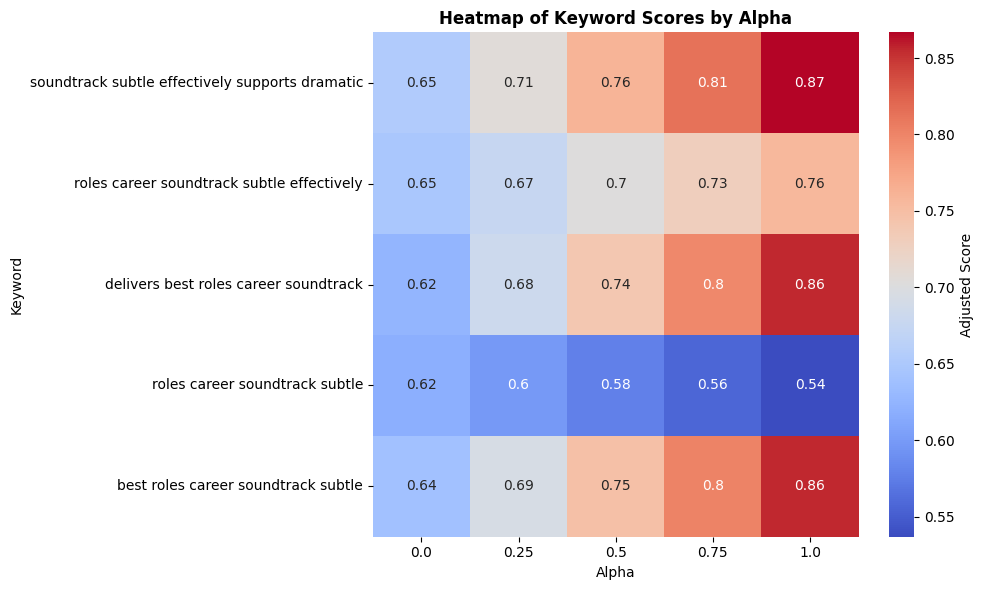

In [ ]:
# Input review
review =  "The movie opens with breathtaking visuals that immediately draw you in. The performances are emotionally resonant, particularly the lead actor who delivers one of the best roles of his career. While the soundtrack is subtle, it effectively supports the dramatic tone of the film. However, the narrative tends to drag in the middle, and some of the dialogue feels forced or overly sentimental. Despite a slightly predictable ending, the film manages to leave a lasting impression through its powerful themes and character development."

# Initialize models
base_model = KeyBERT(model="sentence-transformers/all-MiniLM-L6-v2")
base_keywords = base_model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 2))

# Store results
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
sa_results = {}

# Run sentiment-aware model for different alpha values
for alpha in tqdm(alphas, desc="Running Sentiment-Aware KeyBERT"):
    model = SentimentAwareKeyBERT(alpha=alpha)
    keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 5))[0]  # single review
    sa_results[alpha] = keywords

# Display base results
print("\nBase KeyBERT:")
pprint(base_keywords)

# Display SA-KeyBERT results
for alpha in alphas:
    print(f"\nSA-KeyBERT (alpha={alpha}):")
    pprint(sa_results[alpha])

# Prepare heatmap data
labels = list(set(kw for kwlist in sa_results.values() for kw, _ in kwlist))
scores_by_alpha = {
    alpha: {kw: score for kw, score in sa_results[alpha]} for alpha in alphas
}

heatmap_data = pd.DataFrame({label: [scores_by_alpha[alpha].get(label, 0) for alpha in alphas] for label in labels}, index=alphas)

# Plot: Heatmap of adjusted scores by alpha and keyword
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, annot=True, cmap="coolwarm", cbar_kws={'label': 'Adjusted Score'})
plt.title("Heatmap of Keyword Scores by Alpha", fontweight='bold')
plt.xlabel("Alpha")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


### 2. Multi-review comparison

**Goal:** Observe consistency and performance on a batch of reviews.

- Use a list of 5–10 manually selected reviews with clear sentiment.
- Apply `SentimentAwareKeyBERT` with different `alpha` values.
- Manually or visually evaluate:
  - Do sentimentally aligned keywords consistently rank higher?
  - Is there a value of `alpha` that yields more coherent results?

In [ ]:
# WordCloud of Most Representative Keywords Across All Reviews and Alphas
from wordcloud import WordCloud # type: ignore
from collections import Counter


Aggregating keywords for WordCloud: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


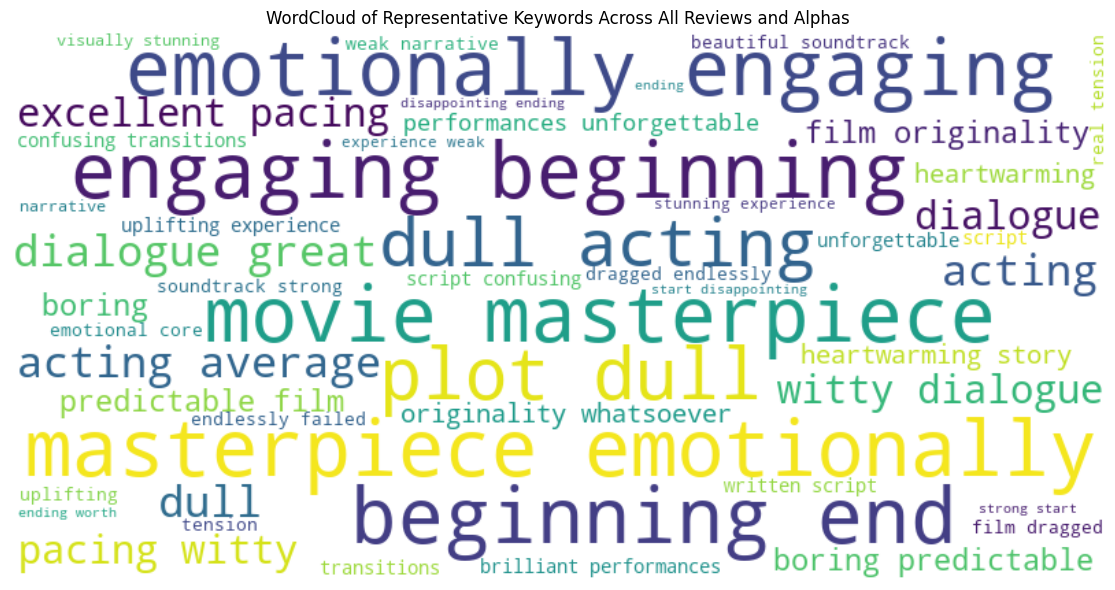

In [45]:
# Multi-review test (Test 2)
reviews = [
    "The movie was a masterpiece, emotionally engaging from beginning to end.",
    "I found the plot dull and the acting below average.",
    "Excellent pacing, witty dialogue, and great direction — truly enjoyable.",
    "It was a boring and predictable film with no originality whatsoever.",
    "Heartwarming story and brilliant performances made it unforgettable.",
    "Terribly written script with confusing transitions and weak characters.",
    "An uplifting experience with a beautiful soundtrack and strong emotional core.",
    "The film dragged on endlessly and failed to deliver any real tension.",
    "A visually stunning experience with a weak narrative.",
    "Strong start but disappointing ending; not worth the hype."
]

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

# Store and collect keywords across all alphas for WordCloud
total_counter = Counter()

for alpha in tqdm(alphas, desc="Aggregating keywords for WordCloud"):
    model = SentimentAwareKeyBERT(alpha=alpha)
    for review in reviews:
        keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 2))[0]
        total_counter.update([kw for kw, _ in keywords])

# WordCloud of Most Representative Keywords Across All Reviews and Alphas
word_freq_dict = dict(total_counter)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Representative Keywords Across All Reviews and Alphas")
plt.tight_layout()
plt.show()


### 3. Dataset test: `preprocessed_others_reviews_df.pkl`

**Goal:** Evaluate performance on a real-world dataset.

- Load the first 100 reviews from this DataFrame.
- Extract keywords using both:
  - `KeyBERT`
  - `SentimentAwareKeyBERT (alpha = 0.5)`
- Optionally log:
  - Sentiment distribution of documents
  - Average position shift of sentiment-aligned keywords

In [49]:
import pickle

Extracting keywords (alpha=0.5): 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


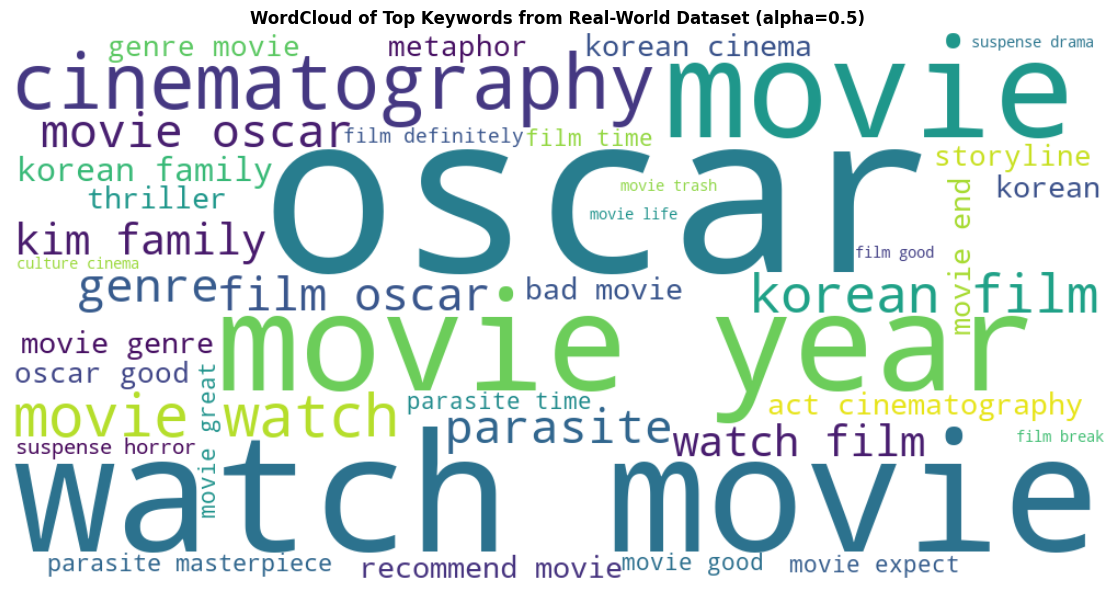

In [50]:
# Load preprocessed dataset
with open("../Dataset/preprocessed_others_reviews_df.pkl", "rb") as f:
    df = pickle.load(f)

# Filter to reviews from the same film (using Movie_ID)
df = df[df["Movie_ID"] == df["Movie_ID"].iloc[0]].head(100)
reviews = df["Processed_Review_Text"].tolist()

# Apply Sentiment-Aware KeyBERT with fixed alpha
alpha = 0.5
model = SentimentAwareKeyBERT(alpha=alpha)

# Extract keywords for each review
all_keywords = []
for review in tqdm(reviews, desc=f"Extracting keywords (alpha={alpha})"):
    keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 2))[0]
    all_keywords.extend([kw for kw, _ in keywords])

# Count most common keywords
counter = Counter(all_keywords)
top_keywords = dict(counter.most_common(40))  # limit to top N to avoid clutter

# Generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(top_keywords)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Top Keywords from Real-World Dataset (alpha=0.5)", fontweight='bold')
plt.tight_layout()
plt.show()


### 4. Domain-specific test: `custom_preprocessed_others_reviews_df.pkl`

**Goal:** Verify generalizability on custom or filtered review data.

- Repeat the same setup as test 3, using the first 100 rows.
- Observe whether sentiment-aware scoring still helps in more homogeneous or biased datasets.

Extracting keywords (alpha=0.5): 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


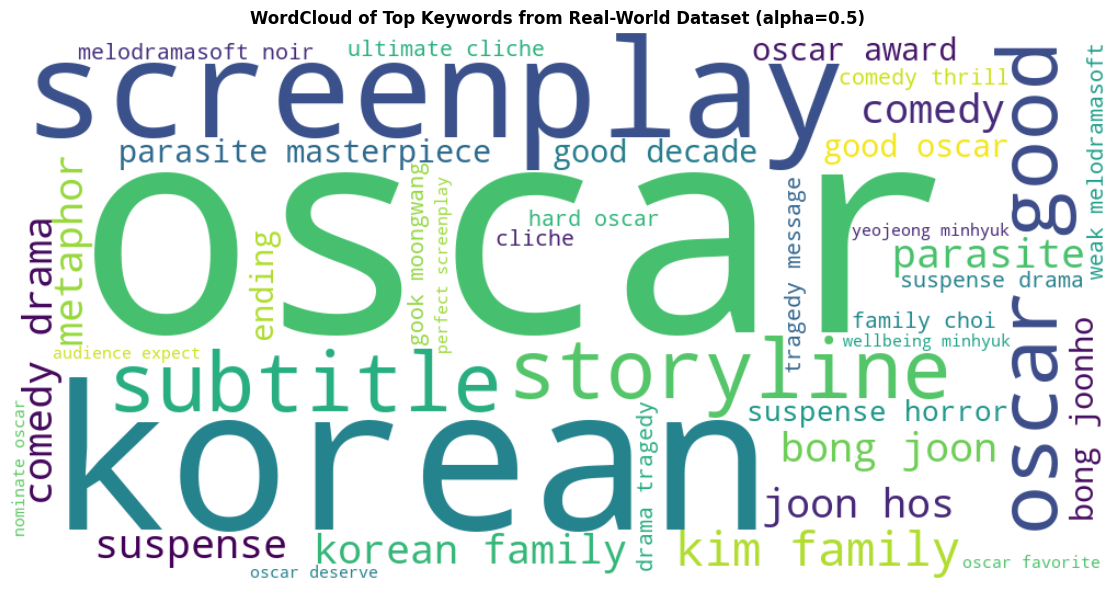

In [51]:
# Load preprocessed dataset
with open("../Dataset/custom_preprocessed_others_reviews_df.pkl", "rb") as f:
    df = pickle.load(f)

# Filter to reviews from the same film (using Movie_ID)
df = df[df["Movie_ID"] == df["Movie_ID"].iloc[0]].head(100)
reviews = df["Processed_Review_Text"].tolist()

# Apply Sentiment-Aware KeyBERT with fixed alpha
alpha = 0.5
model = SentimentAwareKeyBERT(alpha=alpha)

# Extract keywords for each review
all_keywords = []
for review in tqdm(reviews, desc=f"Extracting keywords (alpha={alpha})"):
    keywords = model.extract_keywords(review, top_n=5, keyphrase_ngram_range=(1, 2))[0]
    all_keywords.extend([kw for kw, _ in keywords])

# Count most common keywords
counter = Counter(all_keywords)
top_keywords = dict(counter.most_common(40))  # limit to top N to avoid clutter

# Generate word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(top_keywords)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Top Keywords from Real-World Dataset (alpha=0.5)", fontweight='bold')
plt.tight_layout()
plt.show()
